# Classification IMDb using LSTM
## Importing libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score


In [ ]:
# Memeriksa apakah GPU tersedia
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
# Load dataset IMDb
num_words = 30000  # 30,000 words
maxlen = 300  # Maximum sequence length
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=num_words)


In [ ]:
# Padding sequences
x_train = pad_sequences(x_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)


In [ ]:
# Convert to PyTorch tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.long).to(device)
x_test_tensor = torch.tensor(x_test, dtype=torch.long).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)


In [ ]:
# Create DataLoader for training and testing data
train_data = TensorDataset(x_train_tensor, y_train_tensor)
test_data = TensorDataset(x_test_tensor, y_test_tensor)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)


In [ ]:
# Definisi Model
class DeepNN(nn.Module):
    def __init__(self):
        super(DeepNN, self).__init__()
        self.embedding = nn.Embedding(num_embeddings=num_words, embedding_dim=128)
        self.lstm = nn.LSTM(input_size=128, hidden_size=64, num_layers=1, batch_first=True)
        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm(x)
        x = x[:, -1, :]  # Ambil hidden state terakhir
        x = self.fc1(x)
        x = self.fc2(x)
        return self.sigmoid(x)

In [ ]:
# Inisialisasi model, loss function, dan optimizer
model = DeepNN().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
# Fungsi untuk melatih model di PyTorch (mirip dengan `model.fit()` di TensorFlow)
def train(model, train_loader, criterion, optimizer, num_epochs=5):
    history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}

    for epoch in range(num_epochs):
        model.train()  # Set model ke mode training
        running_loss = 0.0
        correct = 0
        total = 0

        # Training loop
        for inputs, labels in train_loader:
            # Pindahkan data ke perangkat (GPU atau CPU)
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Hitung akurasi
            predicted = (outputs.squeeze() > 0.5).float()  # Ambil prediksi
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct / total

        # Simpan history untuk pelatihan
        history['loss'].append(epoch_loss)
        history['accuracy'].append(epoch_acc)

        # Evaluasi setelah setiap epoch
        val_loss, val_accuracy = evaluate(model, test_loader, criterion)
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_accuracy)

        # Print hasil setiap epoch
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    return history


In [ ]:
# Fungsi untuk evaluasi model (sama seperti sebelumnya)
def evaluate(model, test_loader, criterion):
    model.eval()  # Set model ke mode evaluasi
    running_loss = 0.0
    correct = 0
    total = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            # Pindahkan data ke perangkat (GPU atau CPU)
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            running_loss += loss.item()

            # Ambil prediksi
            predicted = (outputs.squeeze() > 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            # Simpan prediksi dan label untuk metrik lainnya
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = running_loss / len(test_loader)
    accuracy = correct / total

    return avg_loss, accuracy


In [ ]:
# Melatih model
history = train(model, train_loader, criterion, optimizer, num_epochs=5)


Epoch [1/5], Loss: 0.6086, Accuracy: 0.6609, Val Loss: 0.5152, Val Accuracy: 0.7497
Epoch [2/5], Loss: 0.4612, Accuracy: 0.7868, Val Loss: 0.4350, Val Accuracy: 0.8148
Epoch [3/5], Loss: 0.4004, Accuracy: 0.8247, Val Loss: 0.4866, Val Accuracy: 0.7677
Epoch [4/5], Loss: 0.3278, Accuracy: 0.8645, Val Loss: 0.4827, Val Accuracy: 0.7653
Epoch [5/5], Loss: 0.2629, Accuracy: 0.8971, Val Loss: 0.4353, Val Accuracy: 0.8425


In [ ]:
# Menampilkan hasil akhir
print("\nTraining completed.")
print("Final Training Loss: ", history['loss'][-1])
print("Final Training Accuracy: ", history['accuracy'][-1])
print("Final Validation Loss: ", history['val_loss'][-1])
print("Final Validation Accuracy: ", history['val_accuracy'][-1])


Training completed.
Final Training Loss:  0.26292313355237934
Final Training Accuracy:  0.89712
Final Validation Loss:  0.4353120351958153
Final Validation Accuracy:  0.84248


Tensorflow

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
# Build the model using TensorFlow
model = Sequential([
    Embedding(input_dim=num_words, output_dim=128, input_length=maxlen),
    LSTM(128, return_sequences=False),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy', AUC()])


In [ ]:
# Train the model
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=5, batch_size=64)

Epoch 1/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 412s 1s/step - accuracy: 0.6830 - auc_2: 0.7574 - loss: 0.5647 - val_accuracy: 0.8529 - val_auc_2: 0.9299 - val_loss: 0.3530
Epoch 2/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 440s 1s/step - accuracy: 0.9069 - auc_2: 0.9609 - loss: 0.2491 - val_accuracy: 0.8738 - val_auc_2: 0.9445 - val_loss: 0.3135
Epoch 3/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 442s 1s/step - accuracy: 0.9552 - auc_2: 0.9894 - loss: 0.1260 - val_accuracy: 0.8636 - val_auc_2: 0.9384 - val_loss: 0.3568
Epoch 4/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 455s 1s/step - accuracy: 0.9777 - auc_2: 0.9966 - loss: 0.0666 - val_accuracy: 0.8575 - val_auc_2: 0.9224 - val_loss: 0.5265
Epoch 5/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 432s 1s/step - accuracy: 0.9870 - auc_2: 0.9987 - loss: 0.0395 - val_accuracy: 0.8554 - val_auc_2: 0.9207 - val_loss: 0.5279


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Prediksi hasil model pada data uji
y_pred = model.predict(x_test)
y_pred = (y_pred > 0.5)

# Menghitung metrik evaluasi
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
f1_squared = f1 ** 2  # F1 Squared
roc_auc = roc_auc_score(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'AUC: {roc_auc}')


782/782 ━━━━━━━━━━━━━━━━━━━━ 124s 158ms/step
Accuracy: 0.8554
Precision: 0.8337465254300954
Recall: 0.88784
F1 Score: 0.8599434349695866
AUC: 0.8553999999999999


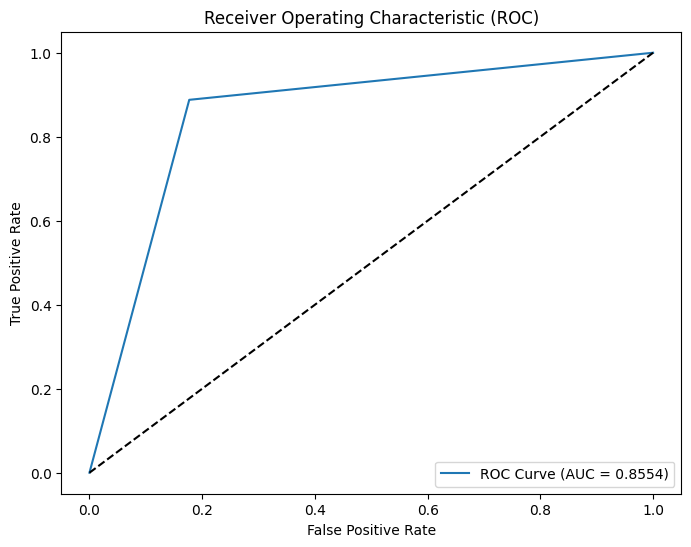

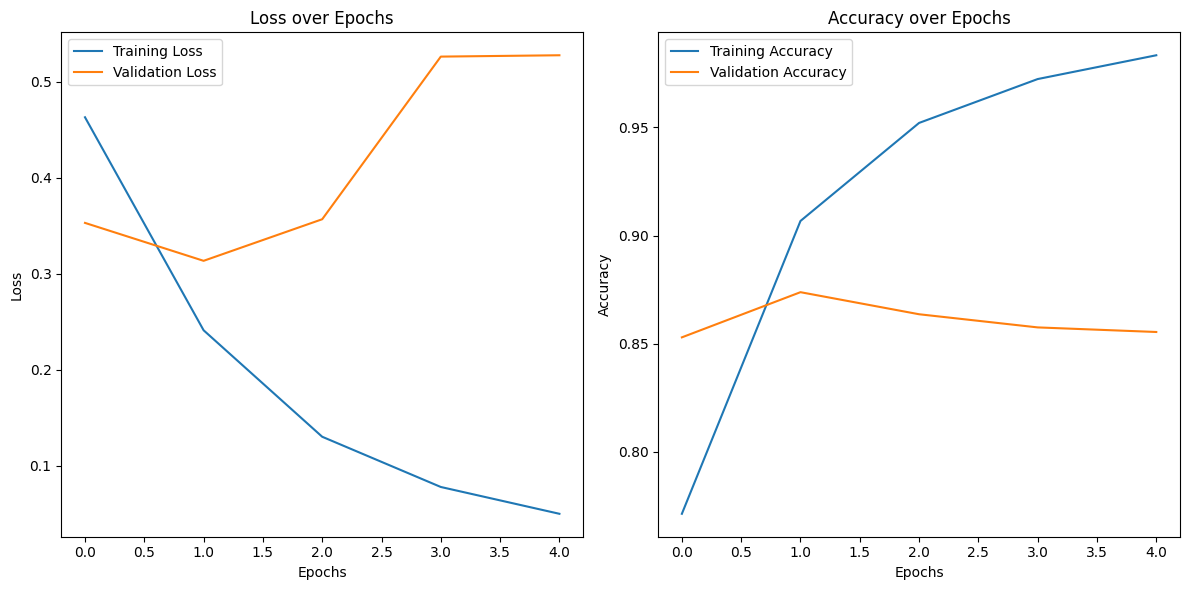

In [ ]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt


# Visualisasi ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

# Visualisasi Loss dan Akurasi
plt.figure(figsize=(12, 6))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

# Penjelasan Metrik Evaluasi Model Klasifikasi

## 1. **Akurasi (Accuracy)**
Akurasi mengukur seberapa sering model menghasilkan prediksi yang benar. Ini dihitung sebagai rasio jumlah prediksi yang benar dengan jumlah total prediksi.

**Persamaan**:
&&
\text{Accuracy} = \frac{\text{TP} + \text{TN}}{\text{TP} + \text{TN} + \text{FP} + \text{FN}}
&&
Dimana:
- **TP (True Positives)**: Jumlah prediksi yang benar untuk kelas positif.
- **TN (True Negatives)**: Jumlah prediksi yang benar untuk kelas negatif.
- **FP (False Positives)**: Jumlah prediksi yang salah untuk kelas positif.
- **FN (False Negatives)**: Jumlah prediksi yang salah untuk kelas negatif.



## 2. **Presisi (Precision)**
Presisi mengukur seberapa tepat model dalam mengklasifikasikan kelas positif. Ini dihitung sebagai rasio jumlah prediksi yang benar untuk kelas positif dibandingkan dengan semua prediksi yang diberikan oleh model sebagai kelas positif.

**Persamaan**:
&&
\text{Precision} = \frac{\text{TP}}{\text{TP} + \text{FP}}
&&
Dimana:
- **TP**: Jumlah prediksi yang benar untuk kelas positif.
- **FP**: Jumlah prediksi yang salah untuk kelas positif.


## 3. **Recall (Sensitivity atau True Positive Rate)**
Recall mengukur seberapa baik model dalam mendeteksi kelas positif. Ini dihitung sebagai rasio jumlah prediksi yang benar untuk kelas positif dibandingkan dengan jumlah total instance yang benar-benar positif.

**Persamaan**:
&&
\text{Recall} = \frac{\text{TP}}{\text{TP} + \text{FN}}
&&
Dimana:
- **TP**: Jumlah prediksi yang benar untuk kelas positif.
- **FN**: Jumlah prediksi yang salah untuk kelas negatif (kesehatan yang positif tetapi salah diklasifikasikan sebagai negatif).


## 4. **F1 Score**
F1 Score adalah ukuran yang menggabungkan presisi dan recall dalam satu angka. Ini adalah rata-rata harmonis dari presisi dan recall, memberikan ukuran yang lebih baik ketika ada ketidakseimbangan kelas (misalnya, jumlah positif jauh lebih sedikit daripada negatif).

**Persamaan**:
&&
\text{F1 Score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
&&
Ini memberikan keseimbangan antara presisi dan recall.


## 5. **F1 Squared**
F1 Squared adalah kuadrat dari F1 Score. Ini mengukur **kuadrat** dari keseimbangan antara presisi dan recall, yang membuatnya lebih sensitif terhadap perubahan kecil dalam F1 Score.

**Persamaan**:
&&
\text{F1 Squared} = (\text{F1 Score})^2
&&
Ini memberikan nilai yang lebih besar (berkisar antara 0 dan 1), dan bisa digunakan untuk pengukuran keakuratan lebih lanjut, dengan menekankan perbedaan kecil antara model yang memiliki F1 Score yang hampir sama.


## 6. **AUC (Area Under the Curve)**
AUC mengukur area di bawah kurva ROC (Receiver Operating Characteristic). AUC memberikan gambaran umum tentang kemampuan model dalam membedakan antara kelas positif dan negatif di semua tingkat keputusan (thresholds). Nilai AUC berkisar antara 0 dan 1, dimana 1 menunjukkan model yang sempurna dan 0.5 menunjukkan model yang tidak lebih baik daripada tebak-tebakan acak.

**Persamaan**:
&&
\text{AUC} = \int_0^1 \text{TPR}(t) \, \text{d}FPR(t)
&&
Dimana:
- **TPR (True Positive Rate)**: Seperti Recall, yaitu rasio instance positif yang terklasifikasi dengan benar.
- **FPR (False Positive Rate)**: Rasio instance negatif yang salah terklasifikasi sebagai positif.
- **t**: Titik threshold.


## 7. **ROC Curve (Receiver Operating Characteristic Curve)**
ROC curve adalah plot yang menunjukkan hubungan antara **True Positive Rate (TPR)** dan **False Positive Rate (FPR)** untuk berbagai nilai threshold.

**Persamaan**:
&&
\text{TPR} = \frac{\text{TP}}{\text{TP} + \text{FN}}
&&
&&
\text{FPR} = \frac{\text{FP}}{\text{FP} + \text{TN}}
&&
Dimana:
- **TPR** adalah True Positive Rate (Recall).
- **FPR** adalah False Positive Rate.

ROC curve menunjukkan seberapa baik model dalam membedakan antara kelas positif dan kelas negatif. Plot ini biasanya menampilkan trade-off antara TPR dan FPR pada berbagai threshold yang berbeda.


## 8. **Contoh Penggunaan**
Jika model Anda memprediksi apakah sebuah email adalah spam atau bukan spam, maka:
- **True Positive (TP)** adalah jumlah email spam yang teridentifikasi sebagai spam.
- **False Positive (FP)** adalah jumlah email non-spam yang salah teridentifikasi sebagai spam.
- **True Negative (TN)** adalah jumlah email non-spam yang teridentifikasi dengan benar sebagai non-spam.
- **False Negative (FN)** adalah jumlah email spam yang salah teridentifikasi sebagai non-spam.

Jika Anda memiliki data yang tidak seimbang (misalnya, lebih banyak email non-spam daripada email spam), model yang hanya mengklasifikasikan sebagian kecil email spam sebagai positif (positif palsu) dapat memiliki nilai **precision** tinggi, tetapi nilai **recall** rendah.


## 9. **Visualisasi**
Setelah menghitung metrik-metrik ini, visualisasi seperti **ROC curve** dan plot **Loss/Accuracy** membantu untuk memahami bagaimana model berfungsi pada data pelatihan dan validasi seiring berjalannya waktu.


Jika ada pertanyaan lebih lanjut atau penjelasan yang dibutuhkan, jangan ragu untuk bertanya!
# Penjelasan Metrik Evaluasi Model Klasifikasi

## 1. **Akurasi (Accuracy)**
Akurasi mengukur seberapa sering model menghasilkan prediksi yang benar. Ini dihitung sebagai rasio jumlah prediksi yang benar dengan jumlah total prediksi.

**Persamaan**:
&&
\text{Accuracy} = \frac{\text{TP} + \text{TN}}{\text{TP} + \text{TN} + \text{FP} + \text{FN}}
&&
Dimana:
- **TP (True Positives)**: Jumlah prediksi yang benar untuk kelas positif.
- **TN (True Negatives)**: Jumlah prediksi yang benar untuk kelas negatif.
- **FP (False Positives)**: Jumlah prediksi yang salah untuk kelas positif.
- **FN (False Negatives)**: Jumlah prediksi yang salah untuk kelas negatif.


## 2. **Presisi (Precision)**
Presisi mengukur seberapa tepat model dalam mengklasifikasikan kelas positif. Ini dihitung sebagai rasio jumlah prediksi yang benar untuk kelas positif dibandingkan dengan semua prediksi yang diberikan oleh model sebagai kelas positif.

**Persamaan**:
&&
\text{Precision} = \frac{\text{TP}}{\text{TP} + \text{FP}}
&&
Dimana:
- **TP**: Jumlah prediksi yang benar untuk kelas positif.
- **FP**: Jumlah prediksi yang salah untuk kelas positif.


## 3. **Recall (Sensitivity atau True Positive Rate)**
Recall mengukur seberapa baik model dalam mendeteksi kelas positif. Ini dihitung sebagai rasio jumlah prediksi yang benar untuk kelas positif dibandingkan dengan jumlah total instance yang benar-benar positif.

**Persamaan**:
&&
\text{Recall} = \frac{\text{TP}}{\text{TP} + \text{FN}}
&&
Dimana:
- **TP**: Jumlah prediksi yang benar untuk kelas positif.
- **FN**: Jumlah prediksi yang salah untuk kelas negatif (kesehatan yang positif tetapi salah diklasifikasikan sebagai negatif).


## 4. **F1 Score**
F1 Score adalah ukuran yang menggabungkan presisi dan recall dalam satu angka. Ini adalah rata-rata harmonis dari presisi dan recall, memberikan ukuran yang lebih baik ketika ada ketidakseimbangan kelas (misalnya, jumlah positif jauh lebih sedikit daripada negatif).

**Persamaan**:
&&
\text{F1 Score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
&&
Ini memberikan keseimbangan antara presisi dan recall.


## 5. **F1 Squared**
F1 Squared adalah kuadrat dari F1 Score. Ini mengukur **kuadrat** dari keseimbangan antara presisi dan recall, yang membuatnya lebih sensitif terhadap perubahan kecil dalam F1 Score.

**Persamaan**:
&&
\text{F1 Squared} = (\text{F1 Score})^2
&&
Ini memberikan nilai yang lebih besar (berkisar antara 0 dan 1), dan bisa digunakan untuk pengukuran keakuratan lebih lanjut, dengan menekankan perbedaan kecil antara model yang memiliki F1 Score yang hampir sama.


## 6. **AUC (Area Under the Curve)**
AUC mengukur area di bawah kurva ROC (Receiver Operating Characteristic). AUC memberikan gambaran umum tentang kemampuan model dalam membedakan antara kelas positif dan negatif di semua tingkat keputusan (thresholds). Nilai AUC berkisar antara 0 dan 1, dimana 1 menunjukkan model yang sempurna dan 0.5 menunjukkan model yang tidak lebih baik daripada tebak-tebakan acak.

**Persamaan**:
&&
\text{AUC} = \int_0^1 \text{TPR}(t) \, \text{d}FPR(t)
&&
Dimana:
- **TPR (True Positive Rate)**: Seperti Recall, yaitu rasio instance positif yang terklasifikasi dengan benar.
- **FPR (False Positive Rate)**: Rasio instance negatif yang salah terklasifikasi sebagai positif.
- **t**: Titik threshold.


## 7. **ROC Curve (Receiver Operating Characteristic Curve)**
ROC curve adalah plot yang menunjukkan hubungan antara **True Positive Rate (TPR)** dan **False Positive Rate (FPR)** untuk berbagai nilai threshold.

**Persamaan**:
&&
\text{TPR} = \frac{\text{TP}}{\text{TP} + \text{FN}}
&&
&&
\text{FPR} = \frac{\text{FP}}{\text{FP} + \text{TN}}
&&
Dimana:
- **TPR** adalah True Positive Rate (Recall).
- **FPR** adalah False Positive Rate.

ROC curve menunjukkan seberapa baik model dalam membedakan antara kelas positif dan kelas negatif. Plot ini biasanya menampilkan trade-off antara TPR dan FPR pada berbagai threshold yang berbeda.


## 8. **Contoh Penggunaan**
Jika model Anda memprediksi apakah sebuah email adalah spam atau bukan spam, maka:
- **True Positive (TP)** adalah jumlah email spam yang teridentifikasi sebagai spam.
- **False Positive (FP)** adalah jumlah email non-spam yang salah teridentifikasi sebagai spam.
- **True Negative (TN)** adalah jumlah email non-spam yang teridentifikasi dengan benar sebagai non-spam.
- **False Negative (FN)** adalah jumlah email spam yang salah teridentifikasi sebagai non-spam.

Jika Anda memiliki data yang tidak seimbang (misalnya, lebih banyak email non-spam daripada email spam), model yang hanya mengklasifikasikan sebagian kecil email spam sebagai positif (positif palsu) dapat memiliki nilai **precision** tinggi, tetapi nilai **recall** rendah.


## 9. **Visualisasi**
Setelah menghitung metrik-metrik ini, visualisasi seperti **ROC curve** dan plot **Loss/Accuracy** membantu untuk memahami bagaimana model berfungsi pada data pelatihan dan validasi seiring berjalannya waktu.

